# Social Computing/Social Gaming - Summer 2021
# Exercise Sheet 4 - Social Tie Strength

In this exercise, you are going to predict Tie Strength in a social network using the method explained in the paper _E. Gilbert and K. Karahalios: Predicting Tie Strength With Social Media_ [1], of which a short introduction is provided to you in the exercise files. According to Mark Granovetter, the strength of a tie between two persons is a combination of the amount of time, the emotional intensity, the intimacy and the reciprocal services which characterize it. Using variables that describe these categories, we want to find out how much each one of these features contributes in order to predict the strength of ties not previously known.<br>
An important prerequisite to this exercise is understanding the basic concept of linear regression models. As mentioned in the lecture, a recommended reading is chapter 3 of _C. Bishop: Pattern Recognition and Machine Learning_ [2], which you can find on [Moodle](https://www.moodle.tum.de/) [3].


### Tie Strength Prediction

In social network analysis, the Tie Strength between two people measures how strong their relationship is. The paper above describes the procedure of deriving available information (different variables) about a connection between two persons from an online social network and using it in order to discover how close they are. The ultimate goal is to build a model using the given information, finding out which variables account most for the Tie Strength and using that model later on to predict social Tie Strength when only the predictive (or explanatory) variables are available. Before being able to predict anything, we need to find out whether the given variables are suitable for prediction in the first place. This can be done via creating and evaluating a **multiple linear regression model**. 'Multiple' here refers to having more than one predictive variable in an regression model.<br>
In the paper mentioned above, 67 variables where used in the linear model to predict the Tie Strength. In our simplified model, we are going to use only 10 predictive variables which are:

<br>
<div>
<img style="margin-left: 5em" src="img.png" width="400"/>
</div>
<br>  






We are going to use a simplified form of the paper's linear model:
$$y_i = \alpha + \beta X_i + \epsilon_i$$

where $y_i$ is the dependent variable (also referred to as target value, which is the Tie Strength in our case) of the $i$-th friend of a person. $X_i$ is the predictive vector, containing the (predictive) variables listed above. $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable, and $\epsilon$ the prediction error. The regression problem boils down to calculating the model's parameters given a certain ground truth; meaning that for some connections, the Tie Strength has to be already known for building the model. That way, the unknown Tie Strengths can be predicted using the regression model by simply inserting the values into the vector. The coefficients for each predictive variable will show us the importance of the respective variable for the social Tie Strength.

### Problem Overview

The input to your Python program is a directed social network _SocialGraph.gml_. As the first step, you will visualize the graph with NetworkX to get an overview over the data.

In practice, the ground truth (Tie Strength in our case) is usually retrieved by participant's answers to surveys on how strong their relationship is with another person - this is why the graph is directed: two people might have varying views. The ground truth is available in the file. About 70% of the edges have valid values for the `tieStrength` variable, which should be used for training. For about 30% of the edges, the variable is set to -1 (equivalent to unknown). These represent the prediction set for which the Tie Strength should be predicted using the linear regression model later. But first, that model needs to be computed and checked for its goodness of fit.

## Task 4.1: Preparations

### a) Imports and Visualization
First, needed libraries and the graph's .gml file have to be imported. The social graph is visualized in order to get an idea what the network actually looks like.
Inspect the plotted graph. **Describe** shortly, what the graph's visualization is telling you, and if there are any problems with this representation. **Any ideas** on how to improve the visualization?

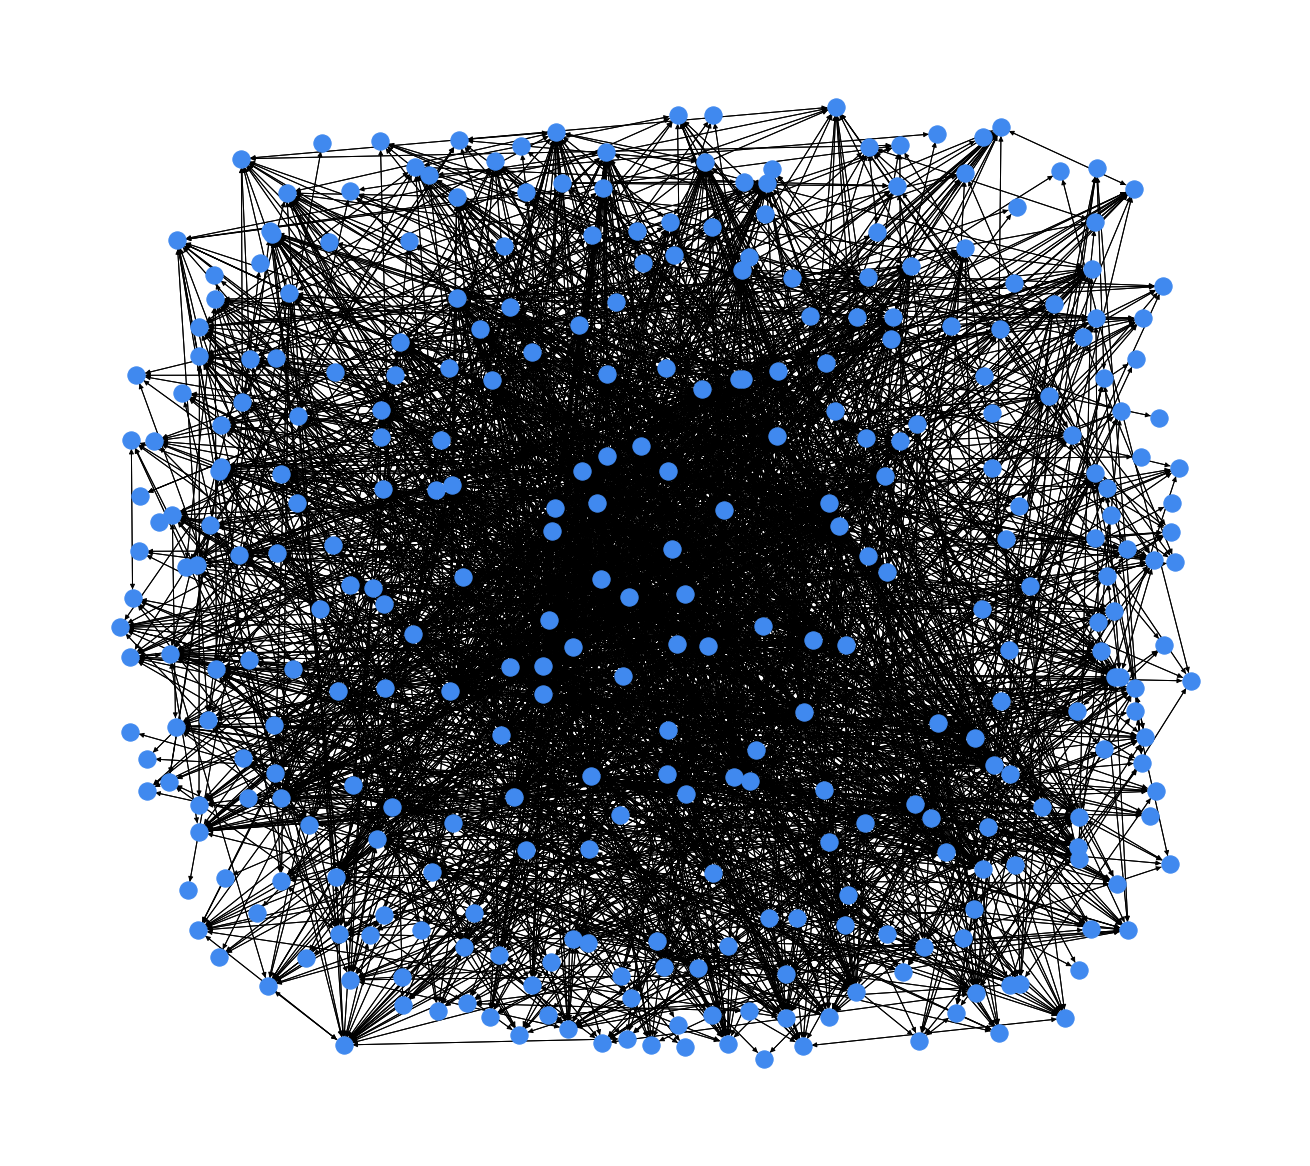

In [1]:
import networkx as nx, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

# read in the structure
g = nx.read_gml('SocialGraph.gml', label='id')


# formatting the graph and applying spring layout
fig=plt.figure(figsize=(18, 16))

pos=nx.spring_layout(g, k=0.4, iterations=5)

visual_style = {
    "node_size": 300,
    "node_color": "#4089EF",
    "bbox" : (700,700), 
    "with_labels" : False
}

nx.draw(g, pos, **visual_style)


**TODO: Write your observations and ideas here**

It looks like as if there are some nodes in the center having connections with a lot of people and some with only little. However, it is not showing at all how strong the tie is between two nodes and if there are concrete clusters in the graph.
Ideas:
- make node size according to degree of node
- make a coloring scheme for the label according to strength of ties
- use a visualization that emphasizes cluster


### b) Complete and convert the data

To further work with our data set, we will now convert it to a [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) [4] dataframe. 
Some of our predictive variables are not yet computed in the _gml_ file, therefore you have to **calculate the missing variables** from the graph's attributes. You can take a look at the _gml_ file as it is human-readable to see what variables are available for you.

In [2]:
# Calculates the missing values for current edge e of graph g
def calculate_missing_variables(g, e):
    # the both nodes connected by edge e
    first, second = e
    # edge data such as firstComm and tieStrength
    edge_data = g.get_edge_data(first, second)
    
    # Source and target nodes for current edge
    src = g.nodes[first]
    tgt = g.nodes[second]
        
    # Already existing variables
    days_last_comm = edge_data['lastComm']
    photos_together = edge_data['photosTogether']
    wall_intim_words = edge_data['wallIntimWords']
    inbox_intim_words = edge_data['inboxIntimWords']
    days_first_comm = edge_data['firstComm']
    
    # The Ground Truth
    tie_strength = edge_data['tieStrength']

    
    # TODO: Compute the missing values
    age_dist = abs(src['age']-tgt['age'])
    edu_diff = abs(src['numAcDegrees']-tgt['numAcDegrees'])
    num_friends = len(g.out_edges(first))
    friends_num_friends = len(g.out_edges(second))
    num_mutual_friends = len([b for (a,b) in g.out_edges(first) for (c,d) in g.out_edges(second)  if (b==d)])

    
    # Create row for dataframe
    row = [num_friends, friends_num_friends, days_last_comm, photos_together, wall_intim_words, inbox_intim_words, days_first_comm, num_mutual_friends, age_dist, edu_diff]
    row = [int(attr) for attr in row]
    row.append(tie_strength) # Appended separately, needs to be float
    
    return row


# Training and prediction lists
data = []
pred_list = []
cols = ['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff', 'Tie Strength']

# Calculate rows (one for each edge) and add them to tables

for e in g.edges:
    row = calculate_missing_variables(g, e)
    
    first, second = e
    edge = g.get_edge_data(first, second)
    
    data.append(row)

data = pd.DataFrame(data, columns=cols)

# Create training and prediction tables
### I changed this from -1 tie strength selection to a 80% train and 20% test split


train_table =data.sample(frac=0.8,random_state=200) #random state is a seed value
pred_table=data.drop(train_table.index)

print(train_table.info())
print(pred_table.info())
print(pred_table.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4030 entries, 4215 to 3932
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   #Friends                4030 non-null   int64  
 1   Friends' #Friends       4030 non-null   int64  
 2   #Days Since Last Comm   4030 non-null   int64  
 3   #Photos                 4030 non-null   int64  
 4   #Wall Intimacy Words    4030 non-null   int64  
 5   #Inbox Intimacy Words   4030 non-null   int64  
 6   #Days Since First Comm  4030 non-null   int64  
 7   #Mutual Friends         4030 non-null   int64  
 8   Age Dist                4030 non-null   int64  
 9   Educational Diff        4030 non-null   int64  
 10  Tie Strength            4030 non-null   float64
dtypes: float64(1), int64(10)
memory usage: 377.8 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008 entries, 2 to 5028
Data columns (total 11 columns):
 #   Column                  Non-Nul

### c) The Variance Inflation Factor (VIF)
Multiple linear regression can hold some pitfalls if you do not evaluate your data beforehands. Such a pitfall is containing multicollinearity in your predictive variables. 

Find out and **explain** in your own words what multicollinearity is, why it forms a danger to linear regression models and how the VIF is linked to that. 
**Create** a temporary dataframe containing only the predictive variables and **add a constant value** to the dataframe for the VIF to produce representative values. Then **compute the VIFs** for them. Statsmodels `variance_inflation_factor()` and `add_constant()` will help you with that. 

Additionally **explain**: What do the results tell you? Do we have to make any adaptions deriving from them?

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant


# TODO: Creat a dataframe, add a constant & compute VIF
tmp_dataframe = train_table.copy()
tmp_dataframe.drop(['Tie Strength'], axis=1,inplace=True)

tmp_dataframe = add_constant(tmp_dataframe)
vif =pd.Series([variance_inflation_factor(tmp_dataframe.values, i)
               for i in range(tmp_dataframe.shape[1])],
              index=tmp_dataframe.columns)
print(vif)



const                     19.593210
#Friends                   1.867015
Friends' #Friends          1.830772
#Days Since Last Comm      1.803210
#Photos                   12.302434
#Wall Intimacy Words      12.305076
#Inbox Intimacy Words      1.001920
#Days Since First Comm     1.802407
#Mutual Friends            2.956920
Age Dist                   1.006720
Educational Diff           1.005974
dtype: float64


**TODO: Write your explanaitions here**

Perfect collinearity means that a perfect linear relationship is present among independent variables. This implies that they are actually the same variable, one is a multiple of the other or a constant has been added to the other.
In consequence if we have perfect Multicollinearty we are incapable of generating estimates of the regression coefficients as one cannot distinguish the perfect collinear variables from each other.

The VIF can help here to quantify the severity of multicollinearity, as it measures by how much the variance of an estimated regression coefficient is increased because of collinearity.

### d) Log-Transformation
In data analysis, transformation is the replacement of a variable by a function of that variable. For example, replacing a variable $x$ by its square root $\sqrt{x}$ or its logarithm $\log{x}$. In a stronger sense, it means a replacement that changes the shape of a distribution or relationship. There are many reasons for transformations. The following list are a few of them but it is not comprehensive:

1. Convenience
2. Reducing skewness
3. Equal spreads
4. Linear relationships
5. Additive relationships

If you are looking at just one explanatory variable, points 1, 2 and 3 are relevant. But considering two or more variables, points 4 and 5 are more important. However, transformations that achieve 4 and 5 very often fulfill 2 and 3 as well.

In our case, a logarithmic transformation on the predictive variables will be used. It will help us to minimize the impact of any non-linearity on our model.

With the help of numpy's `log` function, **apply the log-transformation on each feature vector for the training table (but not the Tie Strength)**. Pay attention to the fact that $\log{0}$ is not defined, a small number (e.g. 0.000001) should be added before the transformation! Again, output the first ten entries of your dataframe.

In [4]:
# TODO: Apply log transformation
feature_vector_names=['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff']

for f_vector in feature_vector_names:
    train_table[f_vector] = np.log(train_table[f_vector]+0.000001)

train_table.head()

,#Friends,Friends' #Friends,#Days Since Last Comm,#Photos,#Wall Intimacy Words,#Inbox Intimacy Words,#Days Since First Comm,#Mutual Friends,Age Dist,Educational Diff,Tie Strength
4215,2.944439,2.890372,4.356709,-13.815511,1.609438,3.784190,5.874931,2.639057,2.944439,-1.381551e+01,0.525435
4910,3.258097,3.555348,4.510860,3.044522,3.688879,3.433987,5.746203,2.079442,0.693148,-1.381551e+01,0.647398
350,2.708050,3.135494,3.737670,-13.815511,1.098613,2.484907,5.916202,2.639057,3.178054,9.999995e-07,0.523562
328,2.772589,2.484907,4.406719,2.833213,3.526361,1.791760,6.495266,0.693148,1.791760,-1.381551e+01,0.678893
4135,2.197225,2.833213,4.912655,2.302585,3.135494,3.178054,5.484797,1.098613,2.197225,9.999995e-07,0.544229


## Task 4.2: The Regression Model

### a) Building the model
**1.**
Finally, the regression can be applied on the dataframe. For this purpose, **split** the dataframe into `y`: the target variable and `X`: the predictive variables. As you have read above, our model contains a bias/intercept named $\alpha$. This will be realized in the model by adding a constant (1.0), that gets multiplied with its own coefficient and therewith forms the intercept. It represents the target value when all explanatory variables are zero. Once again `add_constant(X)` will be of use.

**Split** the dataframe, **add** the constant and then **apply** a multiple linear regression on the training table, the statsmodels functions `OLS()` and `fit()` will help you with that. Output the summary with `model.summary()`.

In [15]:
import statsmodels.api as sm
from scipy import stats
# TODO: Add constant & build the regression model
y = train_table['Tie Strength']
x_train=train_table[feature_vector_names]
x_train=add_constant(x_train)
#print(y.head())

results = sm.OLS(y,x_train).fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:           Tie Strength   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     478.6
Date:                Sun, 20 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:32:39   Log-Likelihood:                 7065.9
No. Observations:                4030   AIC:                        -1.411e+04
Df Residuals:                    4019   BIC:                        -1.404e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

**2.**
As you can see the model's summary provides us with a multitude of informations about its performance. Now we need to evaluate our model based on these values. Find out what the meaning of the following statistics are: `R-squared`, `Adj. R-squared`, `Prob (F-statistic)`, the predicitve variables' significances `P>|t|`. [This site](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/) [5] does a good job explaining them intuitively.

**Evaluate** our model's performance by giving a short comment on the obtained values for them. Don't write more than 5 sentences!


**TODO: Write your evaluation here!**
- F statistic is high and p value 0 -->  The Null Hypotheses, that a model with no independent variables fits the data as well as this model, is rejected at a high level of significance
- R squared is approx. adjusted R squared and with >0.554 relatively high (even higher than the originall paper which reports 0.532 for adj R^2). Further, as they equal, the r squared value shows to not be blown up by to many independent variables.
- All p- values for the independet variable ( apart from the one for Age Distance) are below 0.01 and therefore,  contributing on a statistically significant level.

--> The model provides a good fit, only Age Distance is not really relevant.

**3.**
Now additionally **compare** the obtained coefficients `coef` for our predictive variables to the findings of the paper referenced in [1]. Wich kind of variables (Intimacy, Duration, Structural, Social distance) have the most influence on the Tie Strength according to our regression? You can also comment on specific predicitive variables' values. Keep in mind that the paper's coefficients are already standardized regarding the variabe's values, while ours do not yet compensate for them. Don't write more than 5 sentences.

**TODO: Write your observations here!**

I did run another model containing standardized coefficients .

In [16]:
##
# Standardized Version without constant (not needed with standardization)
##
train_table_standardized = train_table.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
x=train_table_standardized[feature_vector_names]
y = train_table_standardized['Tie Strength']
results_standardized = sm.OLS(y,x).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           Tie Strength   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     478.6
Date:                Sun, 20 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:32:45   Log-Likelihood:                 7065.9
No. Observations:                4030   AIC:                        -1.411e+04
Df Residuals:                    4019   BIC:                        -1.404e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

Using those we can observe:

- Intimacy variables make up for most of the predictive power .
- Second come the duration variables, containing only one variable that overall still has the highest predictive power .
- Third we have the social distance variables in particular the education.
- Last are the structure variables having only little influence

Comparing those groups to the original paper is only partly fair, as the paper has for some groups even more variables.
But, one can see that in terms of ranking our results compare equally, which speaks for our model to work.

### b) OPTIONAL: Goodness of Fit
After you have now analyzed some of the statistics of our model, there are some additional methods of analyzing the Goodness of Fit of our model. There are several methods to evaluate the Goodness of Fit of a regression. In this exercise, you will work with two of them: the Q-Q Plot and the Residual Plot.

**1.: Q-Q Plot**

Create a Q-Q Plot and evaluate what the result means for your fit. Plot the model's residuals on one axis and the normal distribution on the other axis, `scipy.stats` will provide it to you. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** Statsmodles offers a function for Q-Q Plots.

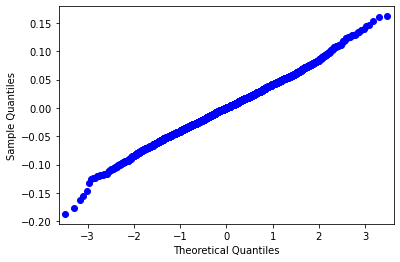

In [17]:
import scipy.stats as stats

# TODO: Create the QQ-Plot
import statsmodels.api as sm
from matplotlib import pyplot as plt
#data = sm.datasets.longley.load(as_pandas=False)
#exog = sm.add_constant(data.exog)
#mod_fit = sm.OLS(data.endog, exog).fit()
res = results.resid # residuals
fig = sm.qqplot(res)
plt.show()


**TODO: Write your interpretation here!**

**2.: Residual Plot**

Now evaluate your fit by plotting the residuals with matplotlib. The plot should show the standardized residuals for each entry. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** The standardized residuals can be accessed via `model.resid_pearson`.

4215   -0.006275
4910    0.039587
350     0.054249
328     0.059014
4135    0.024321
          ...   
1686    0.021161
134     0.010302
3831   -0.024224
421    -0.037245
3932   -0.116723
Length: 4030, dtype: float64
4215    0.531711
4910    0.607811
350     0.469312
328     0.619880
4135    0.519909
          ...   
1686    0.497066
134     0.530710
3831    0.519916
421     0.529280
3932    0.539064
Length: 4030, dtype: float64


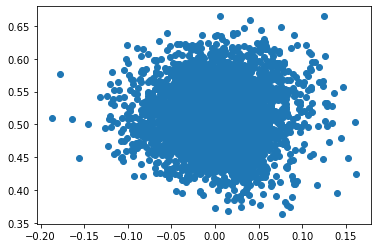

In [18]:
# TODO: Create the Residual-Plot
pred = results.predict(x_train)

import matplotlib.pyplot as plt

plt.scatter(res,pred)

plt.show()



**TODO: Write your interpretation here!**

## Task 4.3: Prediction of Tie Strengths
As a last step, the missing tie string values (marked with -1) for the entries contained in the `pred_table` should be predicted using the before computed regression model. **Use the regression model to predict the missing Tie Strength values.** Statsmodels will be of help with that. **Remember** that we transformed the training data with a log-transform and added an intercept, so this needs to be done here as well. Output the first ten entries.

In [19]:
# TODO: Perform log transformation, add constant & predict the Tie Strengths

feature_vector_names=['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff']
pred_copy = pred_table.copy()
for f_vector in feature_vector_names:
    pred_copy[f_vector] = np.log(pred_copy[f_vector]+0.000001)

x=pred_copy[feature_vector_names]
x=add_constant(x)
# as this is not supposed by the task I will do the predictions without the standardization

pred_table['Prediction'] = results.predict(x)
print(pred_copy.head(10))

# An example for queries:
# pred_table[pred_table['Tie Strength'] > 0.7].head(5)

    #Friends  Friends' #Friends  #Days Since Last Comm       #Photos  \
2   2.772589           1.945910               3.737670  9.999995e-07   
17  2.197225           2.995732               4.343805  2.079442e+00   
18  2.197225           2.772589               4.615121  6.931477e-01   
37  2.772589           2.564949               4.477337  1.098613e+00   
48  2.197225           2.079442               5.342334 -1.381551e+01   
57  2.484907           3.044522               5.003946  2.564949e+00   
65  1.609438           1.609438               5.783825 -1.381551e+01   
67  2.944439           2.302585               4.317488 -1.381551e+01   
72  2.944439           2.708050               4.605170  6.931477e-01   
76  2.944439           3.637586               5.549076  1.098613e+00   

    #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
2               2.397895               2.397895                5.693732   
17              2.890372               2.484907          


**Are the predictions in line with the observations above? Pick a few entries to back up your observations.** If you would like to talk about other than the first ten entries, you can query a pandas dataframe similar to SQL. More information on how to do this is available in the [pandas documenation](https://pandas.pydata.org/pandas-docs/version/0.19.2/comparison_with_sql.html) [4].

In [20]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(pred_table['Tie Strength'], pred_table['Prediction'], squared=False))
print("Min :",pred_table['Tie Strength'].min())
print("Max :",pred_table['Tie Strength'].max())
print(" Mean :",pred_table['Tie Strength'].mean())

print("Var :",pred_table['Tie Strength'].var())
print("Prediction Min :",pred_table['Prediction'].min())
print("Prediction Max :",pred_table['Prediction'].max())
print("Prediction Mean :",pred_table['Prediction'].mean())
print("Prediction Var :",pred_table['Prediction'].var())
print("Hight tie strength:")
print(pred_table[pred_table['Prediction'] > 0.6].head(5))
print("Low tie strength:")

print(pred_table[pred_table['Prediction'] < 0.4].head(5))

print("Below 0 tie strength:")
print(pred_table[pred_table['Prediction'] < 0.0].head(5))

0.040313397404460063
Min : 0.32029831301976
Max : 0.815514721678735
 Mean : 0.5147513103083811
Var : 0.004027065435225869
Prediction Min : 0.3481175303804389
Prediction Max : 0.6515180623249578
Prediction Mean : 0.5140122484973958
Prediction Var : 0.002205829819832292
Hight tie strength:
     #Friends  Friends' #Friends  #Days Since Last Comm  #Photos  \
146        56                 27                    161        9   
352        15                 17                    118        4   
511        12                 35                    102       16   
659        23                 25                    162       22   
981        75                 31                    211       11   

     #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
146                    16                     22                     986   
352                    18                     13                     765   
511                    31                     20                     707  

As you might discover, there are some Tie Strength values slightly below zero. Can you **explain** that behaviour?

**TODO: Write your observation and explanation here!**

- Age Dist doesnt matter, in both sample high and low tie strength, there is an arbitrary selection
- Days Since First Communication, which was identified as most important variable, has huge values for high Tie strength and low values for low tie strength
- Days Since Last Communication is not as supposed. High Values should result in less predicted tie strength however, in the above sample its the other way round
- Educational Difference is as supposed, high values here are punished by the fitted model and result in less predicted tie strength
- Wall Intimacy word is as supposed, high values here are punished by the fitted model and result in less predicted tie strength
- Min, Max and Variance of predictions and actual Values are quite similiar

In general the model seams to work quite well the predictions and GT values have similiar min max boundaries as well as a similiar mean and variance.
Also for most (in particular the ones with the highest standardized coeffs) of the independent variables, the influence interpretations of above seem to hold.

While I cannot observe any <0 predictions (maybe there is some flaw in my input variable calculation) this probably might occur if there are any
test samples that have a quite different value structure then the ones used for training.
Having e.g. a sample with very high educational difference / days since last communication / ( variables with negative coeff in the fitted model) ... while having 0 values for the rest of the independent variables might result in a negative prediction

## References

[1] E. Gilbert and K. Karahalios: _Predicting Tie Strength With Social Media_. Proceedings of the SIGCHI Conference on Human Factors in Computing Systems. ACM, 2009.
<br>[2] C. Bishop: _Pattern Recognition and Machine Learning_. 2006.
<br>[3] https://www.moodle.tum.de/
<br>[4] https://pandas.pydata.org/docs/user_guide/index.html
<br>[5] https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/